In [1]:
"""
PanoLLaVA Processor 사용 예제
"""

import sys
import os
from panovlm.processors.image import PanoramaImageProcessor
from panovlm.processors.text import TextTokenizer
from panovlm.processors.vision import VisionProcessorWrapper
from panovlm.processors.builder import ConversationPromptBuilder
from panovlm.processors.pano_llava_processor import PanoLLaVAProcessor
import math
from typing import Union, List, Dict, Any, Tuple, Optional

import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Try to import py360convert, handle error if not found
try:
    from py360convert import e2p, e2c
except ImportError:
    print("Warning: 'py360convert' library not found. 'e2p' and 'cubemap' strategies will not work.")
    print("Please install it using: pip install py360convert")
    e2p = e2c = None

def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().permute(1, 2, 0).numpy()
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

def visualize_views(
    pixel_values: torch.Tensor,
    title: str,
    *,  # [핵심 수정] 이 뒤의 인자는 반드시 키워드로만 전달해야 함
    titles: Optional[List[str]] = None,
    filename: Optional[str] = None,
    show_plot: bool = False
):
    """
    Create and save or show a visualization of the processed views.
    Optional arguments after '*' must be passed as keyword arguments.
    """
    if not filename and not show_plot:
        print("Warning: No action taken. Either 'filename' must be provided or 'show_plot' must be True.")
        return

    views = pixel_values.squeeze(0)
    num_views = views.shape[0]
    
    if num_views <= 4:
        nrows, ncols = 1, num_views
    else:
        nrows = 2
        ncols = math.ceil(num_views / 2)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4 + 1))
    axes = np.ravel(axes)
    
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_views):
        view_tensor = views[i]
        img = denormalize(view_tensor)
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    for i in range(num_views, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if filename:
        plt.savefig(filename)
        print(f"Saved visualization to {filename}")
    
    if show_plot:
        plt.show()

    plt.close(fig)

# --- Main Execution ---
    
# 이미지와 텍스트 처리
sample_image = "data/quic360/downtest/images/26286679561_2bc4360f7d_f.jpg"
sample_text = "이 사진에서 가장 눈에 띄는 것은 무엇인가요?"

/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeysView({'pixel_values': tensor([[[[ 1.0502,  1.0331,  1.0331,  ..., -0.5424, -0.7822,  0.2624],
          [ 1.0502,  1.0673,  1.0502,  ..., -0.5424, -0.8507, -0.4397],
          [ 1.0844,  1.1015,  1.0502,  ..., -0.6965, -0.6623,  0.5364],
          ...,
          [ 1.3413,  1.1529,  0.8789,  ..., -1.5014, -1.4843, -0.6965],
          [ 1.2557,  0.9988,  1.0844,  ..., -1.3473, -1.5014, -0.4739],
          [ 1.4098,  1.2043,  1.1700,  ..., -1.0904, -1.3130, -0.6109]],

         [[ 1.2381,  1.2381,  1.2206,  ..., -0.9853, -0.8277,  0.2752],
          [ 1.2381,  1.2556,  1.2206,  ..., -0.9153, -1.0203, -0.5651],
          [ 1.2731,  1.2906,  1.2206,  ..., -1.0378, -0.7927, -0.0399],
          ...,
          [ 0.4503,  0.0126, -0.2150,  ..., -1.8606, -1.8081, -1.1253],
          [ 0.2402, -0.1450, -0.0749,  ..., -1.7031, -1.8081, -0.7927],
          [ 0.3627,  0.0301, -0.0224,  ..., -1.4055, -1.5805, -0.8627]],

         [[ 1.0539,  1.0365,  0.9494,  ..., -1.0550, -0.8807,  0.2348],
    

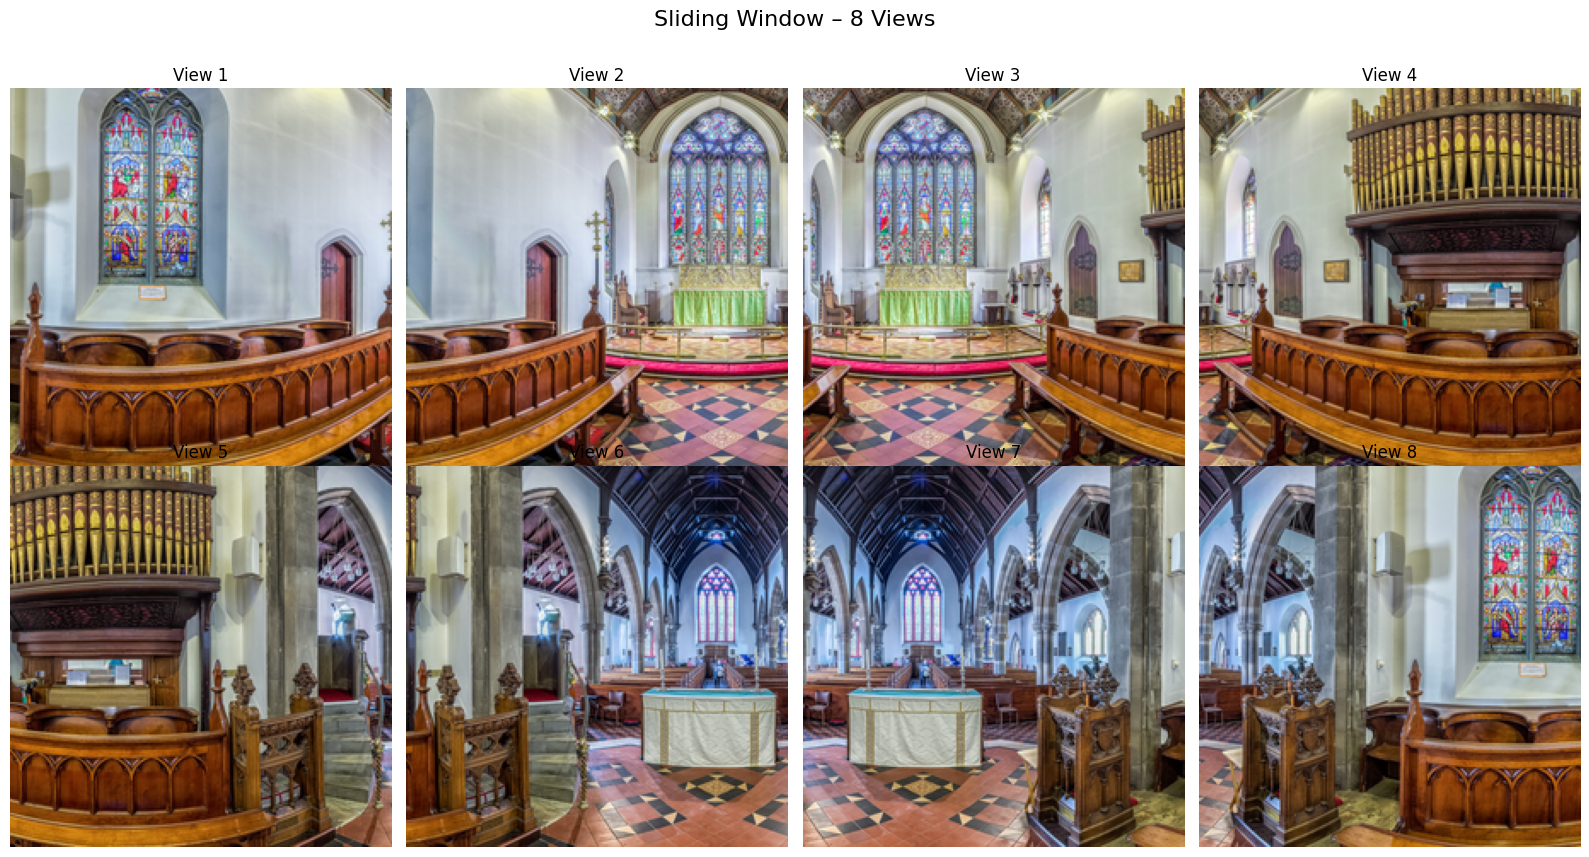

In [2]:
# ① 파노라마 → 멀티뷰 변환
img_proc = PanoramaImageProcessor(
    image_size    =(224, 224),
    crop_strategy ="sliding_window",   # 또는 "e2p" / "cubemap" /"anyres"/"sliding_window"
    fov_deg       =90,
    overlap_ratio =0.5,
    normalize= True,
    anyres_max_patches=8
)

# ② 텍스트 토크나이저
txt_tok  = TextTokenizer("Qwen/Qwen3-0.6B")

# ③ (선택) CLIP·ViT용 비전 프로세서
# vis_proc = VisionProcessorWrapper("google/siglip-so400m-patch14-384")

# ④ 최종 통합 Processor
pano_proc = PanoLLaVAProcessor(img_proc, txt_tok)

# ── (2) 대화 프롬프트 빌더 ───────────────────────────────────
builder = ConversationPromptBuilder(
    txt_tok.tok,
    system_msg="당신은 360° 파노라마 분석 전문가입니다.",
)

builder.push("user", "이 방은 어떤 스타일인가요?")

# ── (3) 실제 데이터 전처리 ──────────────────────────────────
image = Image.open(sample_image).convert("RGB")

batch = pano_proc(
    pil     = image,
    builder = builder,
    flatten = False                 # (B, V, C, H, W) 그대로 유지
)

print(batch.keys())
print("pixel_values shape:", batch["pixel_values"].shape)  # (B, V, C, H, W)
print("input_ids shape:", batch["input_ids"].shape)  # (B, L)
print("attention_mask shape:", batch["attention_mask"].shape)  # (B, L
# dict_keys(['pixel_values', 'pixel_values_5d', 'input_ids', 'attention_mask'

num_v = batch["pixel_values"].shape[0]

visualize_views(
    batch["pixel_values"],
    title = f"Sliding Window – {num_v} Views",
    titles= [ f"View {i+1}" for i in range(num_v) ],
    show_plot= True
)